In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
print('device:', tf.config.list_physical_devices('GPU')) #P100 GPU

2025-09-29 17:33:33.911686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759167214.152015      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759167214.220678      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
train_dir = '/kaggle/input/google-recaptcha/data/train'
test_dir = '/kaggle/input/google-recaptcha/data/test'
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True
)
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [3]:
train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = True
)
test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = False
)
class_label = list(train_generator.class_indices.keys())

Found 9384 images belonging to 12 classes.
Found 2346 images belonging to 12 classes.


In [4]:
print(class_label)

['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair', 'Traffic Light']


In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

base_model = InceptionV3(
    weights = 'imagenet', #load pretrained weights gained from ImageNet dataset
    include_top = False,
    input_tensor = Input(shape = (150, 150, 3))
)

I0000 00:00:1759167239.393443      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [6]:
for layer in base_model.layers[:260]:
    layer.trainable = False
for layer in base_model.layers[260:]:
    layer.trainable = True

In [7]:
from tensorflow.keras.optimizers import Adam
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(class_label), activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)
model.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
trainable_param = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print('Trainable:',trainable_param)
non_trainable_param = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
print('Nontrainable:',non_trainable_param)

Trainable: 8799180
Nontrainable: 14187104


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint_path = '/kaggle/working/model.keras'
early_stop = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights = True)
checkpoint = ModelCheckpoint(checkpoint_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

In [9]:
history = model.fit(
    train_generator,
    epochs = 100,
    validation_data = test_generator,
    callbacks = [early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)
I0000 00:00:1759167265.731511      73 service.cc:148] XLA service 0x7c92a8068f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759167265.732676      73 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759167268.200887      73 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/147 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.1094 - loss: 2.5481    

I0000 00:00:1759167280.123798      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.3654 - loss: 1.9547
Epoch 1: val_loss improved from inf to 0.91001, saving model to /kaggle/working/model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 161s 876ms/step - accuracy: 0.3661 - loss: 1.9525 - val_accuracy: 0.7131 - val_loss: 0.9100
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.6111 - loss: 1.2049
Epoch 2: val_loss improved from 0.91001 to 0.75232, saving model to /kaggle/working/model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 62s 422ms/step - accuracy: 0.6113 - loss: 1.2044 - val_accuracy: 0.7472 - val_loss: 0.7523
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6814 - loss: 0.9910
Epoch 3: val_loss improved from 0.75232 to 0.70096, saving model to /kaggle/working/model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 62s 421ms/step - accuracy: 0.6814 - loss: 0.9909 - val_accuracy: 0.7626 - val_loss: 0.7010
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7055 - loss: 0.8879
Epoch 4: va

In [10]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_label = list(test_generator.class_indices.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(64, 150, 150, 3))
  warnings.warn(msg)


37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 295ms/step


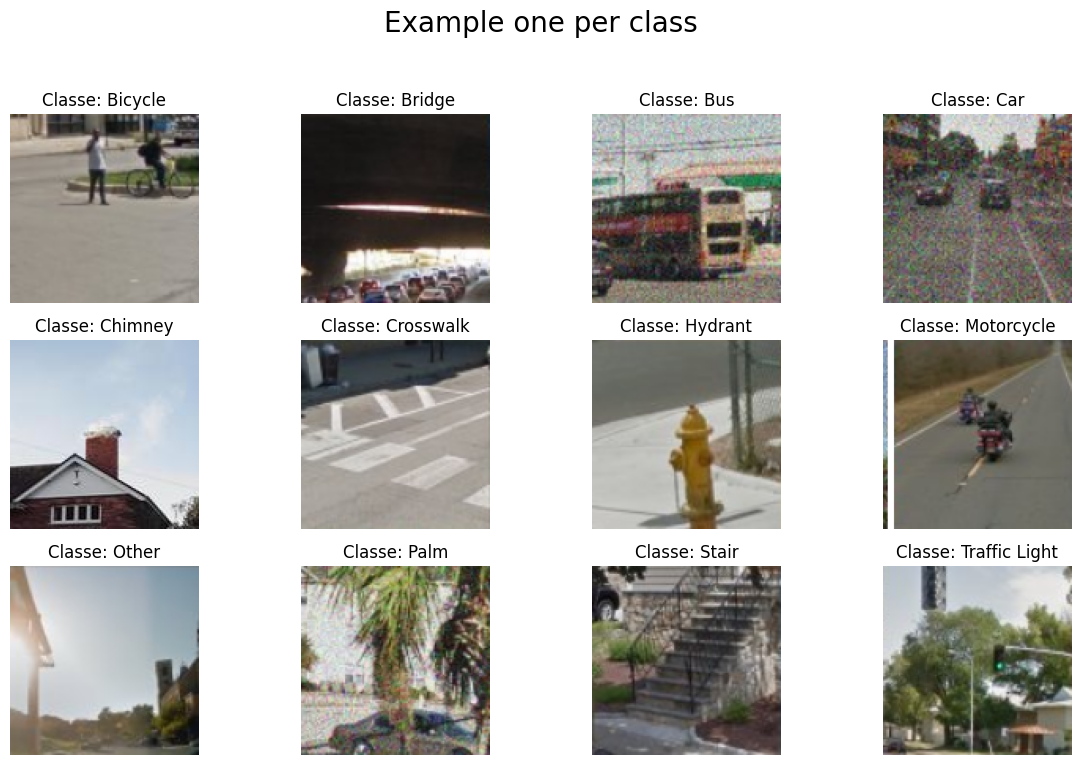

In [11]:
from PIL import Image
class_examples = {}
for index in range(len(predicted_classes)):
    true = true_classes[index]
    pred = predicted_classes[index]

    if true == pred and true not in class_examples:
        class_examples[true] = index
    if len(class_examples) == len(class_label):
        break
fig, axes = plt.subplots(3, 4, figsize = (12, 8))
fig.suptitle('Example one per class', fontsize = 20)
for i , (class_index, img_index) in enumerate(class_examples.items()):
    ax = axes[i // 4, i % 4]
    img_path = test_generator.filepaths[img_index]
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f'Classe: {class_label[class_index]}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step


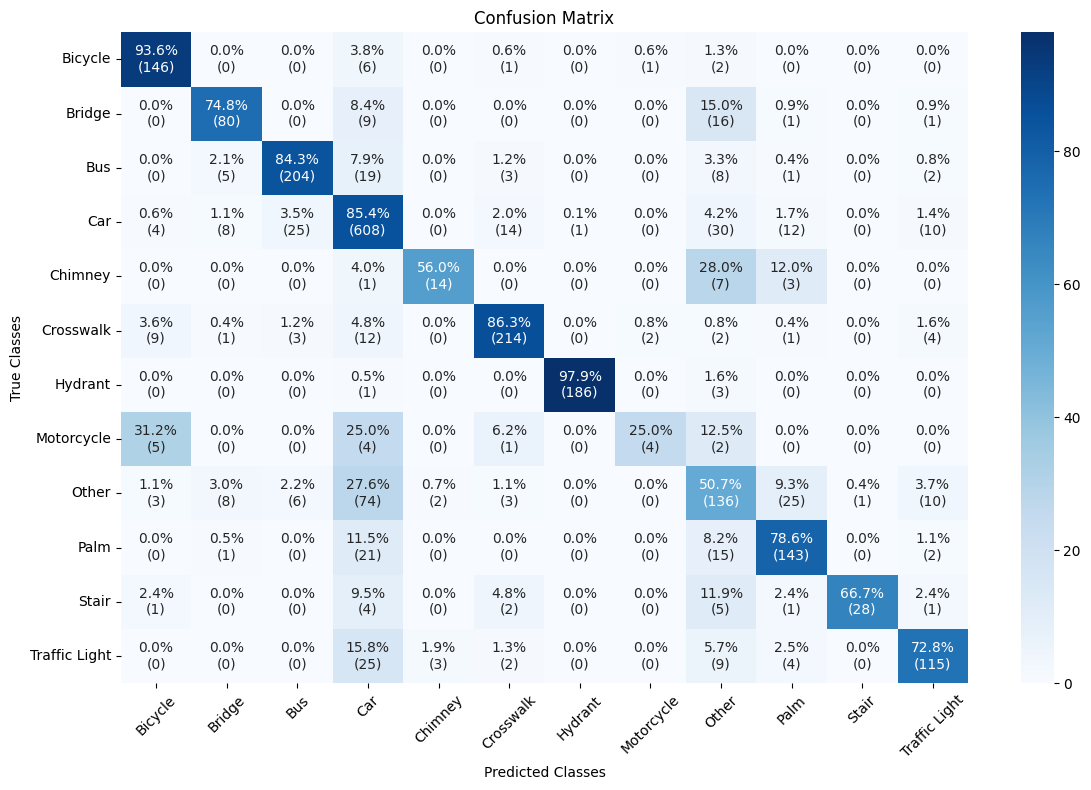

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_probs = model.predict(test_generator)
predicted_classes = np.argmax(y_pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

annotations = np.empty_like(cm).astype(str)
n_classes = len(class_labels)
for i in range(n_classes):
    for j in range(n_classes):
        percent = cm_percent[i, j]
        count = cm[i, j]
        annotations[i, j] = f'{percent:.1f}%\n({count})'

plt.figure(figsize=(12, 8))
sns.heatmap(cm_percent, annot=annotations, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.title('Confusion Matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4)
print("Precision Report by Class:\n")
print(report)

Precision Report by Class:

               precision    recall  f1-score   support

      Bicycle     0.8690    0.9359    0.9012       156
       Bridge     0.7767    0.7477    0.7619       107
          Bus     0.8571    0.8430    0.8500       242
          Car     0.7755    0.8539    0.8128       712
      Chimney     0.7368    0.5600    0.6364        25
    Crosswalk     0.8917    0.8629    0.8770       248
      Hydrant     0.9947    0.9789    0.9867       190
   Motorcycle     0.5714    0.2500    0.3478        16
        Other     0.5787    0.5075    0.5408       268
         Palm     0.7487    0.7857    0.7668       182
        Stair     0.9655    0.6667    0.7887        42
Traffic Light     0.7931    0.7278    0.7591       158

     accuracy                         0.8005      2346
    macro avg     0.7966    0.7267    0.7524      2346
 weighted avg     0.7985    0.8005    0.7973      2346



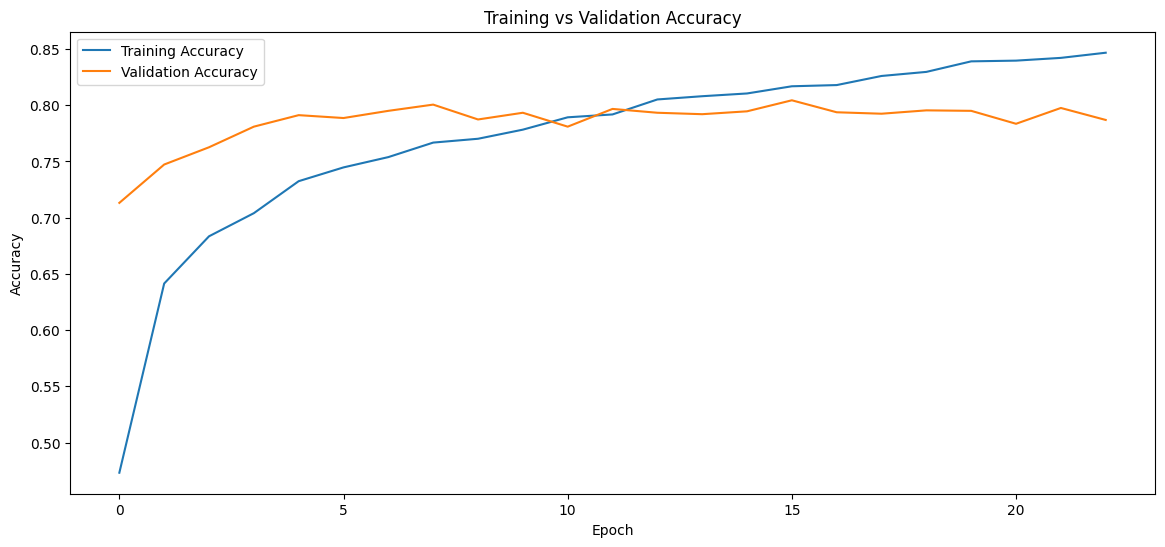

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [15]:
best_model = tf.keras.models.load_model(checkpoint_path)
loss, acc = best_model.evaluate(test_generator, verbose=0)
print(f'Best saved model - Loss: {loss:.4f}, Accuracy: {acc:.4f}')

Best saved model - Loss: 0.6277, Accuracy: 0.8005
